TODO: option to save everything as SVG and CSV, and add statistics for CDFs,  add n for metrics

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import seaborn as sns
from collections import namedtuple
from scipy.optimize import curve_fit
from ht2.io_handler import *

sns.set_theme("notebook", "white")

def batch_read_idealized(fpath_list):
    idl_df = []
    for i, fpath in enumerate(fpath_list):
        raw_trace = pd.read_csv(fpath, sep="\s+", index_col=False, header=None)
        raw_trace.columns = ["x", "y", "I", "t", "spots"]
        idl_trace = fpath.parent.joinpath(fpath.name[:-4] + "_idealized_traces.txt")
        idl_trace = pd.read_csv(idl_trace, sep="\s+", index_col=False, header=None)
        G = idl_trace[0]
        G[G == G.max()] = 1
        G[G == G.min()] = 0
        raw_trace["Normalized Intensity"] = raw_trace["I"] - np.percentile(raw_trace["I"], 30)
        raw_trace["Normalized Intensity"] = raw_trace["Normalized Intensity"] / np.percentile(raw_trace["Normalized Intensity"], 98)
        raw_trace["Time (min)"] = raw_trace["t"] * 100 / 60
        raw_trace["State"] = idl_trace[0]
        idl_df.append(raw_trace)
    return idl_df

def read_cond_traces(cond_path: Path):
    cpath = cond_path.joinpath("coupled")

    cg_trace_list = cpath.glob("*G_Dual*.trk")
    cg_trace_df = batch_read_idealized(cg_trace_list)
    cr_trace_list = cpath.glob("*R_Dual*.trk")
    cr_trace_df = batch_read_idealized(cr_trace_list)

    return {"G":cg_trace_df, "R":cr_trace_df}

In [2]:
parent_path = Path(r"C:\Users\Imageanalysis\Desktop\Ike\New")
path_list = sorted(parent_path.glob("*/"))
cond_Iames = ["Fibronectin", 
              "Laminin", 
              "Soft FN", 
              "Soft Lam", 
              "Stiff FN", 
              "Stiff Lam", 
              "20% Stretch", 
              "0% Stretch", 
              "Control", 
              "Hypotonic", 
              "Compression"]
[print(dirpath.name, " || ", cond) for dirpath, cond in zip(path_list, cond_Iames)]

001-1MaxIP_fn  ||  Fibronectin
001-1MaxIP_lam  ||  Laminin
003-4_soft_fn  ||  Soft FN
003-4_soft_lam  ||  Soft Lam
003-4_stiff_fn  ||  Stiff FN
003-4_stiff_lam  ||  Stiff Lam
004-4MaxIP_STRETCH_20  ||  20% Stretch
005-1MaxIP_STRETCH_0  ||  0% Stretch
009-0Cont  ||  Control
47_49HypOtonic_hyp_ctrl  ||  Hypotonic
56Compression  ||  Compression


[None, None, None, None, None, None, None, None, None, None, None]

In [184]:
def arrange_heatmap(results, max_length=0, spacing=0):
    t_start = [trace["t"][np.argmax(trace["Normalized Intensity"])]for trace in results["G"]]
    sort_idx = np.argsort(t_start)
    G_df = [results["G"][i] for i in sort_idx]
    R_df = [results["R"][i] for i in sort_idx]
    # G_df = results["G"]
    # R_df = results["R"]
    heat_map_arr = np.ones((len(G_df) * (2+spacing), max_length)) * 0.5
    for i in range(len(G_df)):
        G_df[i]["trace"], R_df[i]["trace"] = i, i

    # G_df = pd.concat(G_df)
    # R_df = pd.concat(R_df)
    # heat_map_arr = np.zeros()
    for i, (g_trace, r_trace) in enumerate(zip(G_df, R_df)):
        g_vals = g_trace["Normalized Intensity"][0:min(len(g_trace["t"]), max_length)]
        g_vals[g_vals < 0] = 0
        g_vals[g_vals > 1] = 1
        g_vals = g_vals / 2 + 0.5
        r_vals = r_trace["Normalized Intensity"][0:min(len(g_trace["t"]), max_length)]
        r_vals[r_vals < 0] = 0
        r_vals[r_vals > 1] = 1
        r_vals = 0.5 - r_vals / 2
        heat_map_arr[i * (2+spacing), 0:min(len(g_trace["t"]), max_length)] = g_vals
        heat_map_arr[i * (2+spacing) + 1, 0:min(len(r_trace["t"]), max_length) ] = r_vals

    return heat_map_arr

def heatmap_csv(results, out):
    df = {}
    for i, (g_trace, r_trace) in enumerate(zip(results["G"], results["R"])):
        g_vals = g_trace["Normalized Intensity"].copy()
        g_vals[g_vals < 0] = 0
        g_vals[g_vals > 1] = 1
        r_vals = r_trace["Normalized Intensity"].copy()
        r_vals[r_vals < 0] = 0
        r_vals[r_vals > 1] = 1
        df["{}_G".format(i)] = g_vals
        df["{}_R".format(i)] = r_vals
    df = pd.DataFrame(df)
    df.to_csv(out)
    return df



In [310]:
path_list

[WindowsPath('C:/Users/Imageanalysis/Desktop/Ike/New/001-1MaxIP_fn'),
 WindowsPath('C:/Users/Imageanalysis/Desktop/Ike/New/001-1MaxIP_lam'),
 WindowsPath('C:/Users/Imageanalysis/Desktop/Ike/New/003-4_soft_fn'),
 WindowsPath('C:/Users/Imageanalysis/Desktop/Ike/New/003-4_soft_lam'),
 WindowsPath('C:/Users/Imageanalysis/Desktop/Ike/New/003-4_stiff_fn'),
 WindowsPath('C:/Users/Imageanalysis/Desktop/Ike/New/003-4_stiff_lam'),
 WindowsPath('C:/Users/Imageanalysis/Desktop/Ike/New/004-4MaxIP_STRETCH_20'),
 WindowsPath('C:/Users/Imageanalysis/Desktop/Ike/New/005-1MaxIP_STRETCH_0'),
 WindowsPath('C:/Users/Imageanalysis/Desktop/Ike/New/009-0Cont'),
 WindowsPath('C:/Users/Imageanalysis/Desktop/Ike/New/47_49HypOtonic_hyp_ctrl'),
 WindowsPath('C:/Users/Imageanalysis/Desktop/Ike/New/56Compression')]

In [311]:
stretch = read_cond_traces(path_list[6])
ctrl = read_cond_traces(path_list[7])

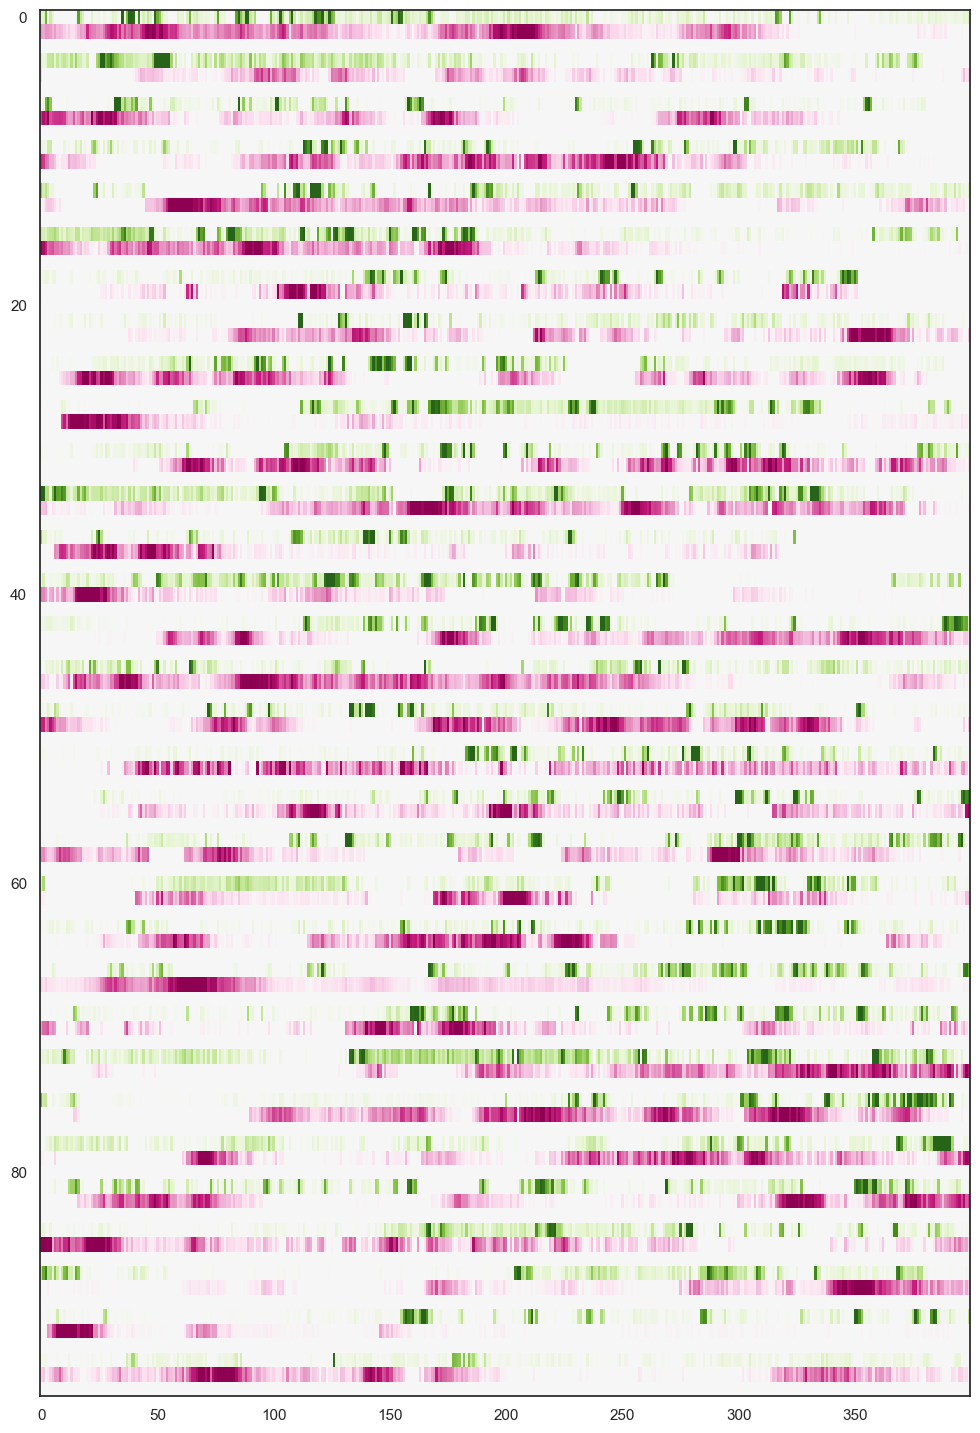

In [185]:
results = read_cond_traces(path_list[-3])
heatmap_arr = arrange_heatmap(results, 400, spacing=1)
plt.figure(figsize=(12, 18))
plt.imshow(heatmap_arr, aspect="auto", interpolation="nearest", cmap="PiYG")
plt.show()

In [118]:
def arrange_heatmap_clustered(results, sort_idx=None, max_length=0, spacing=0, ):
    if sort_idx is None:
        sort_idx = np.arange(len(results["G"]))
    G_df = [results["G"][i] for i in range(len(results["G"]))]
    R_df = [results["R"][i] for i in range(len(results["R"]))]
    heat_map_arr = np.ones((len(G_df) * (2+spacing), max_length)) * 0.5
    
    for j, (g_trace, r_trace, i) in enumerate(zip(G_df, R_df, sort_idx)):
        g_vals = g_trace["Normalized Intensity"][0:min(len(g_trace["t"]), max_length)]
        g_vals[g_vals < 0] = 0
        g_vals[g_vals > 1] = 1
        g_vals = g_vals / 2 + 0.5
        r_vals = r_trace["Normalized Intensity"][0:min(len(r_trace["t"]), max_length)]
        r_vals[r_vals < 0] = 0
        r_vals[r_vals > 1] = 1
        r_vals = 0.5 - r_vals / 2
        heat_map_arr[i * (2+spacing), 0:min(len(g_trace["t"]), max_length)] = r_vals
        heat_map_arr[i * (2+spacing) + 1, 0:min(len(r_trace["t"]), max_length) ] = g_vals
    return heat_map_arr

In [315]:
def get_catch22_features(results):
    g_df = [results["G"][i]["Normalized Intensity"] for i in range(len(results["G"]))]
    r_df = [results["R"][i]["Normalized Intensity"] for i in range(len(results["R"]))]
    g_ts_df = [pd.DataFrame.from_dict(c22.catch22_all(ts)).set_index("names").transpose() for ts in g_df]
    g_ts_df = pd.concat(g_ts_df).reset_index().drop(columns=["index"]).reset_index()
    r_ts_df = [pd.DataFrame.from_dict(c22.catch22_all(ts)).set_index("names").transpose() for ts in r_df]
    r_ts_df = pd.concat(r_ts_df).reset_index().drop(columns=["index"]).reset_index()
    gr_df = g_ts_df.merge(r_ts_df, how="left", on="index", suffixes=("_G", "_R"), ).drop(columns=["index"])
    return g_ts_df.drop(columns=["index"]), r_ts_df.drop(columns=["index"]), gr_df

In [316]:
stretch_g, stretch_r, stretch_gr = get_catch22_features(stretch)
ctrl_g, ctrl_r, ctrl_gr = get_catch22_features(ctrl)

In [ ]:
def get_burst_metrics(intensity, states, state = 1):
    burst_lengths = np.diff(np.where(np.diff(states) == 1)[0])
    burst_freqs = 1 / burst_lengths
    dS = np.diff(states, prepend=np.array([0]))
    blocks = np.cumsum(dS != 0)
    on_labeled = (states == 1) * blocks
    on_times = np.bincount(on_labeled)[1:]
    on_idxs = np.arange(1, len(on_times) + 1)
    on_idxs = on_idxs[on_times > 0]
    on_times = on_times[on_times > 0]

    off_labeled = (states == 0) * blocks
    off_times = np.bincount(off_labeled)[1:]
    off_idxs = np.arange(1, len(off_times) + 1)
    off_idxs = off_idxs[off_times > 0]
    off_times = off_times[off_times > 0]
    on_sizes = []
    for i in on_idxs:
        on_sizes.append(np.sum(intensity * (on_labeled == i)))
    off_sizes = []
    for i in off_idxs:
        off_sizes.append(np.sum(intensity * (off_labeled == i)))
    return on_times, off_times, np.array(on_sizes), np.array(off_sizes), burst_freqs

In [332]:
stretch_control = pd.concat([stretch_gr, ctrl_gr])
labels = np.concatenate([np.ones(6), np.zeros(10)])
stretch_control

names,DN_HistogramMode_5_G,DN_HistogramMode_10_G,CO_f1ecac_G,CO_FirstMin_ac_G,CO_HistogramAMI_even_2_5_G,CO_trev_1_num_G,MD_hrv_classic_pnn40_G,SB_BinaryStats_mean_longstretch1_G,SB_TransitionMatrix_3ac_sumdiagcov_G,PD_PeriodicityWang_th0_01_G,...,FC_LocalSimple_mean1_tauresrat_R,DN_OutlierInclude_p_001_mdrmd_R,DN_OutlierInclude_n_001_mdrmd_R,SP_Summaries_welch_rect_area_5_1_R,SB_BinaryStats_diff_longstretch0_R,SB_MotifThree_quantile_hh_R,SC_FluctAnal_2_rsrangefit_50_1_logi_prop_r1_R,SC_FluctAnal_2_dfa_50_1_2_logi_prop_r1_R,SP_Summaries_welch_rect_centroid_R,FC_LocalSimple_mean3_stderr_R
0,-0.579852,-0.219936,3.227151,8.0,0.127956,0.349121,0.949477,15.0,0.011317,8.0,...,0.021277,-0.297391,-0.073043,0.793666,6.0,1.949838,0.826087,0.869565,0.085903,0.601252
1,0.385885,-0.647445,7.401108,11.0,0.126517,-0.204508,0.952962,28.0,0.003333,11.0,...,0.011628,-0.773913,0.285217,0.880123,6.0,1.868352,0.565217,0.282609,0.073631,0.496084
2,-0.813491,-1.006403,29.650993,24.0,0.537525,0.078660,0.799492,113.0,0.062500,120.0,...,0.007634,-0.400000,0.915190,0.850193,7.0,1.877007,0.133333,0.800000,0.049087,0.503243
3,-0.789372,-0.366346,11.309046,14.0,0.152982,0.245424,0.956446,50.0,0.080000,19.0,...,0.037037,-0.191304,0.217391,0.868856,6.0,1.877314,0.739130,0.543478,0.073631,0.493242
4,0.285714,0.020285,7.572194,8.0,0.193161,-0.047231,0.965157,54.0,0.018519,13.0,...,0.012987,0.405217,-0.022609,0.837503,7.0,1.838716,0.521739,0.826087,0.079767,0.577007
5,-0.125916,0.265343,23.640556,2.0,0.171270,0.373999,0.937282,50.0,0.022039,3.0,...,0.006494,0.697391,-0.471304,0.876640,6.0,1.781827,0.434783,0.847826,0.024544,0.480998
0,-0.742943,-0.399435,1.411206,4.0,0.052569,-0.594496,0.953988,10.0,0.020833,4.0,...,0.027027,-0.042813,0.171254,0.920117,7.0,1.651159,0.133333,0.822222,0.073631,0.440619
1,-0.488101,-0.238201,15.114548,25.0,0.301617,0.086550,0.925087,71.0,0.021915,112.0,...,0.007194,0.262609,-0.227826,0.863004,6.0,1.835147,0.326087,0.130435,0.061359,0.516686
2,-0.047766,-0.362669,3.994791,8.0,0.192455,0.381379,0.942675,31.0,0.055556,8.0,...,0.027778,-0.258475,0.741525,0.818772,7.0,1.929371,0.739130,0.543478,0.073631,0.586364
3,-0.772924,-0.464392,2.672038,9.0,0.123094,0.243425,0.968641,14.0,0.007545,9.0,...,0.010204,-0.001739,0.409565,0.820882,7.0,1.803056,0.130435,0.869565,0.055223,0.568347


In [ ]:
def batch_trace_extract_feature(trace_list):
    g_df = [results["G"][i]["Normalized Intensity"] for i in range(len(results["G"]))]
    r_df = [results["R"][i]["Normalized Intensity"] for i in range(len(results["R"]))]
    g_ts_df = [pd.DataFrame.from_dict(c22.catch22_all(ts)).set_index("names").transpose() for ts in g_df]
    g_ts_df = pd.concat(g_ts_df).reset_index().drop(columns=["index"]).reset_index()
    r_ts_df = [pd.DataFrame.from_dict(c22.catch22_all(ts)).set_index("names").transpose() for ts in r_df]
    r_ts_df = pd.concat(r_ts_df).reset_index().drop(columns=["index"]).reset_index()
    gr_df = g_ts_df.merge(r_ts_df, how="left", on="index", suffixes=("_G", "_R"), ).drop(columns=["index"])
    

In [101]:
g_df = [results["G"][i]["Normalized Intensity"] for i in range(len(results["G"]))]
r_df = [results["R"][i]["Normalized Intensity"] for i in range(len(results["R"]))]
g_ts_df = [pd.DataFrame.from_dict(c22.catch22_all(ts)).set_index("names").transpose() for ts in g_df]
g_ts_df = pd.concat(g_ts_df).reset_index().drop(columns=["index"]).reset_index()
r_ts_df = [pd.DataFrame.from_dict(c22.catch22_all(ts)).set_index("names").transpose() for ts in r_df]
r_ts_df = pd.concat(r_ts_df).reset_index().drop(columns=["index"]).reset_index()
gr_df = g_ts_df.merge(r_ts_df, how="left", on="index", suffixes=("_G", "_R"), ).drop(columns=["index"])
gr_df

names,DN_HistogramMode_5_G,DN_HistogramMode_10_G,CO_f1ecac_G,CO_FirstMin_ac_G,CO_HistogramAMI_even_2_5_G,CO_trev_1_num_G,MD_hrv_classic_pnn40_G,SB_BinaryStats_mean_longstretch1_G,SB_TransitionMatrix_3ac_sumdiagcov_G,PD_PeriodicityWang_th0_01_G,...,FC_LocalSimple_mean1_tauresrat_R,DN_OutlierInclude_p_001_mdrmd_R,DN_OutlierInclude_n_001_mdrmd_R,SP_Summaries_welch_rect_area_5_1_R,SB_BinaryStats_diff_longstretch0_R,SB_MotifThree_quantile_hh_R,SC_FluctAnal_2_rsrangefit_50_1_logi_prop_r1_R,SC_FluctAnal_2_dfa_50_1_2_logi_prop_r1_R,SP_Summaries_welch_rect_centroid_R,FC_LocalSimple_mean3_stderr_R
0,-0.746689,-0.472664,9.645995,11.0,0.258341,0.200701,0.888502,68.0,0.040000,11.0,...,0.010204,0.219130,-0.443478,0.877011,9.0,1.701484,0.152174,0.130435,0.030680,0.494554
1,-0.889183,-0.612318,4.858232,8.0,0.271327,0.157605,0.837413,34.0,0.104167,8.0,...,0.016949,0.830716,0.111693,0.934942,6.0,1.757658,0.195652,0.195652,0.042951,0.395109
2,-1.052748,-0.731608,2.267106,7.0,0.145240,0.047896,0.803136,27.0,0.012153,7.0,...,0.005525,-0.575652,0.506087,0.953614,8.0,1.693476,0.869565,0.869565,0.012272,0.326320
3,-0.139600,-0.537197,5.187642,21.0,0.131702,0.271243,0.728223,28.0,0.025510,32.0,...,0.011628,0.271304,-0.276522,0.946920,6.0,1.704350,0.586957,0.804348,0.049087,0.354422
4,-0.230759,-0.496582,2.359351,9.0,0.071470,0.242629,0.791289,16.0,0.003945,13.0,...,0.021277,-0.315217,-0.027174,0.832234,7.0,1.847387,0.304348,0.826087,0.067495,0.566931
5,-0.535470,-0.784504,3.170037,6.0,0.154485,0.358279,0.746241,15.0,0.080000,9.0,...,0.017241,-0.908068,0.221388,0.872923,6.0,1.915957,0.717391,0.652174,0.067495,0.488330
6,-0.866161,-0.625178,3.174307,5.0,0.189745,0.226057,0.724206,12.0,0.033531,9.0,...,0.005128,-0.738614,0.651485,0.979543,8.0,1.616247,0.652174,0.869565,0.024544,0.208282
7,0.085819,-0.279285,2.267321,5.0,0.063844,0.114604,0.768293,15.0,0.005301,6.0,...,0.010417,-0.941739,0.166087,0.964866,7.0,2.086548,0.630435,0.282609,0.085903,0.334881
8,-0.178743,-0.508724,2.758335,8.0,0.067775,-0.031477,0.792683,33.0,0.005208,11.0,...,0.015152,-0.481739,0.880000,0.856981,6.0,1.835966,0.847826,0.369565,0.055223,0.550180
9,-0.732874,-0.421853,2.924750,4.0,0.128602,0.267978,0.735192,16.0,0.012500,10.0,...,0.029412,-0.306087,0.784348,0.848519,6.0,1.932536,0.543478,0.434783,0.085903,0.563535


In [267]:
g_r_ts_df = pd.concat([g_ts_df, r_ts_df]).drop(columns=["index"])

In [296]:
for name in g_r_ts_df.columns:
    print(name)

DN_HistogramMode_5
DN_HistogramMode_10
CO_f1ecac
CO_FirstMin_ac
CO_HistogramAMI_even_2_5
CO_trev_1_num
MD_hrv_classic_pnn40
SB_BinaryStats_mean_longstretch1
SB_TransitionMatrix_3ac_sumdiagcov
PD_PeriodicityWang_th0_01
CO_Embed2_Dist_tau_d_expfit_meandiff
IN_AutoMutualInfoStats_40_gaussian_fmmi
FC_LocalSimple_mean1_tauresrat
DN_OutlierInclude_p_001_mdrmd
DN_OutlierInclude_n_001_mdrmd
SP_Summaries_welch_rect_area_5_1
SB_BinaryStats_diff_longstretch0
SB_MotifThree_quantile_hh
SC_FluctAnal_2_rsrangefit_50_1_logi_prop_r1
SC_FluctAnal_2_dfa_50_1_2_logi_prop_r1
SP_Summaries_welch_rect_centroid
FC_LocalSimple_mean3_stderr


In [277]:
import matplotlib as mpl

In [278]:
cmap = mpl.colormaps["Paired"]

In [273]:
points = np.concatenate([np.ones(32), np.zeros(32)])

In [269]:
import umap
import umap.plot as uplt

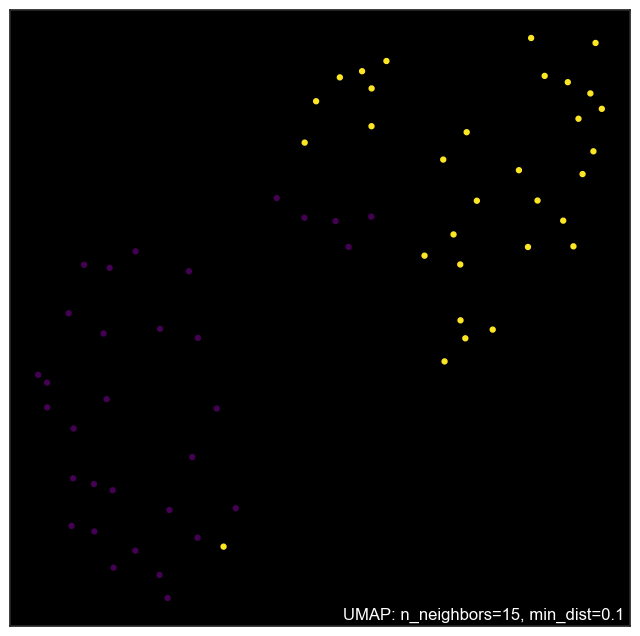

In [413]:
umapper = umap.UMAP(n_neighbors=15, n_components=2)
gr_mapper = umapper.fit(g_r_ts_df)
uplt.points(gr_mapper, values=points * 100, theme="viridis")
plt.show()

In [336]:
def plot_UMAP(features, labels, n=20):
    umapper = umap.UMAP(n_neighbors=n, n_components=2)
    gr_mapper = umapper.fit(features)
    uplt.points(gr_mapper, values=labels * 100, theme="viridis")
    plt.show()

In [339]:
def plot_PCA(features, labels):
    pca = PCA(n_components=2)
    X_decomp = pca.fit_transform(features)
    plt.scatter(X_decomp[:, 0], X_decomp[:, 1], c=cmap(labels))
    plt.show()

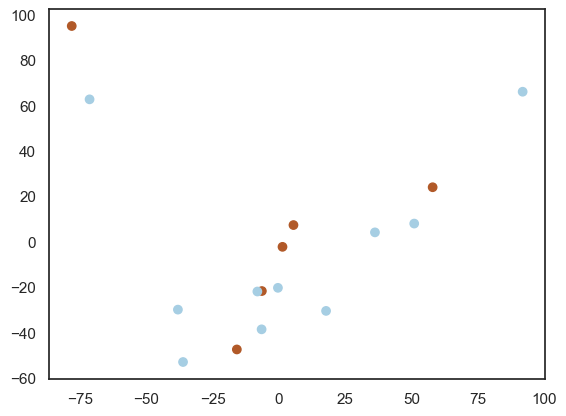

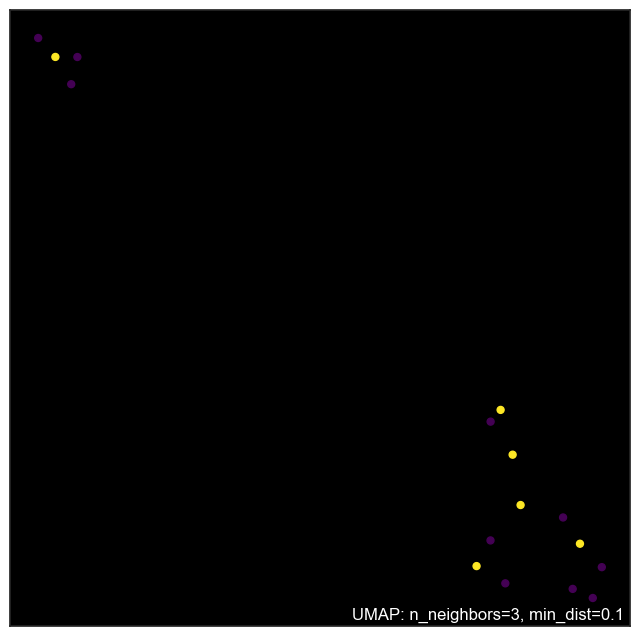

In [402]:
plot_PCA(stretch_control, labels)
plot_UMAP(stretch_control, labels, n=3)

ValueError: Values must have a value for each sample (size mismatch: 16 64)

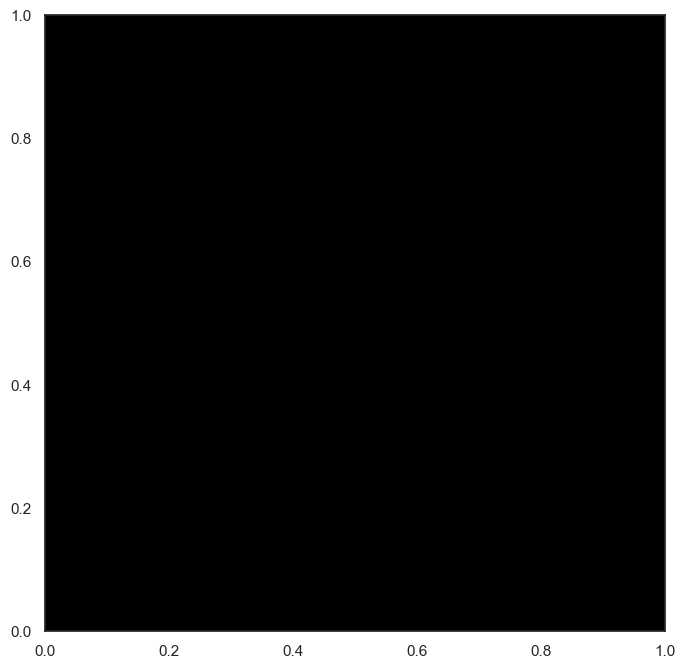

In [407]:
plot_UMAP(g_r_ts_df, labels, 20)

<function matplotlib.pyplot.show(close=None, block=None)>

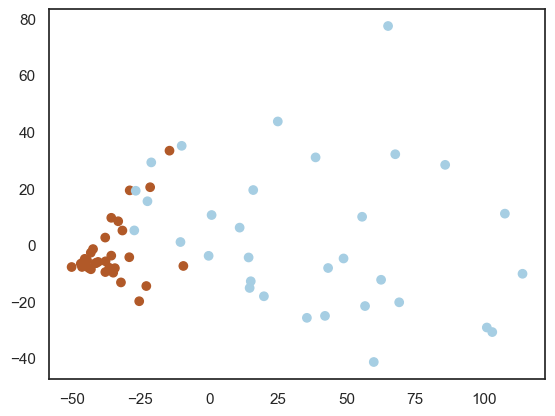

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_decomp = pca.fit_transform(g_r_ts_df)
plt.scatter(X_decomp[:, 0], X_decomp[:, 1], c=cmap(points))
plt.show()

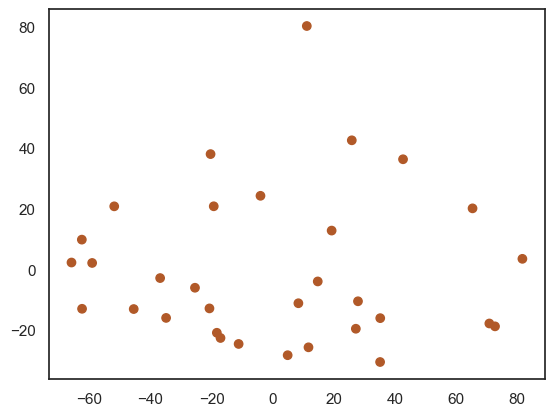

In [399]:
plot_PCA(gr_df, labels = np.ones(len(gr_df)))

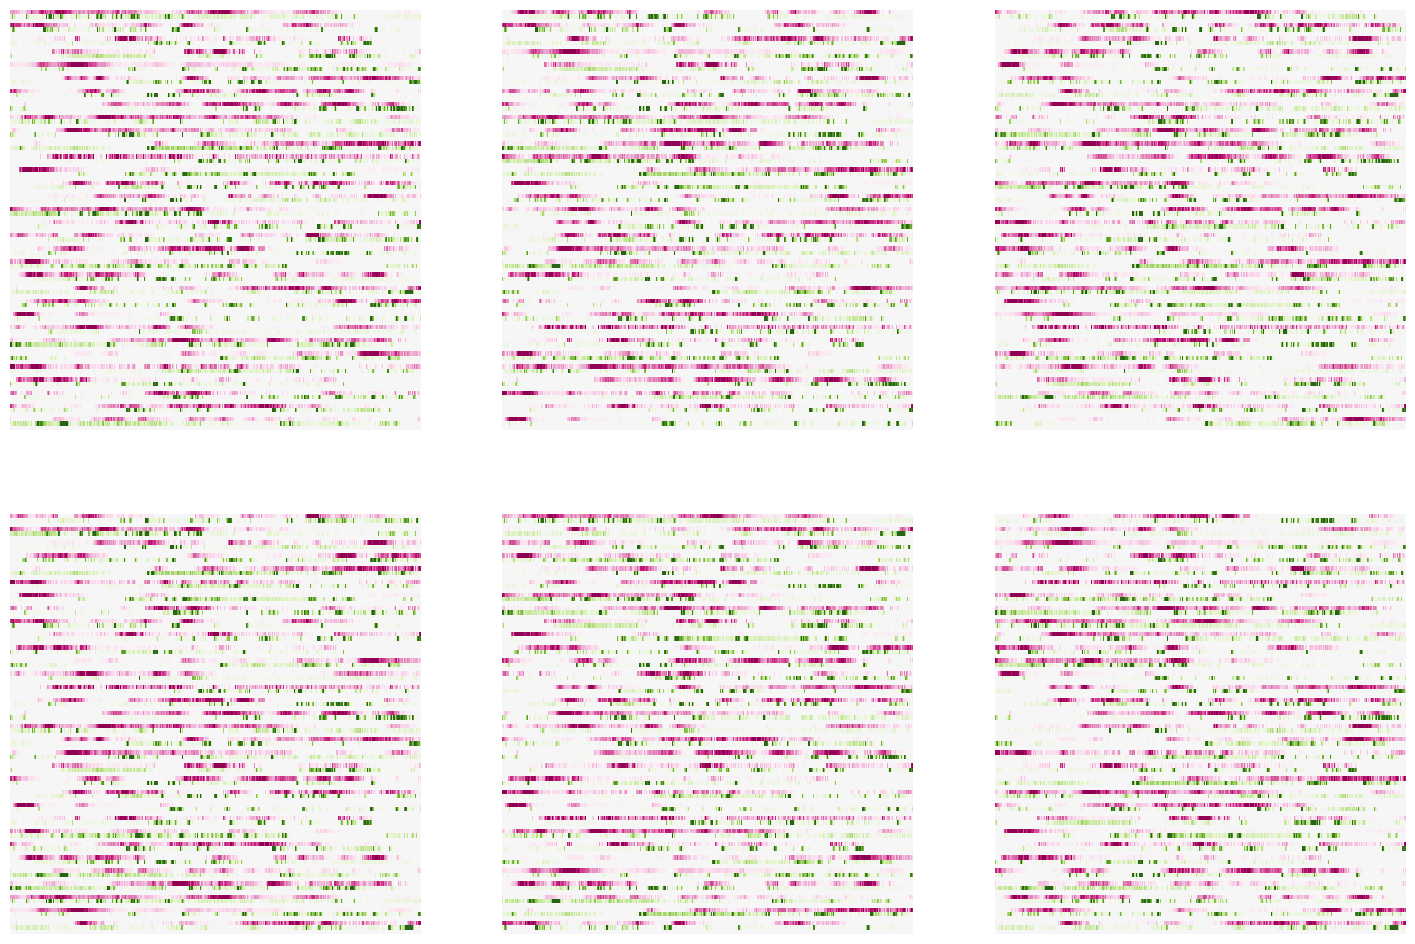

In [ ]:
import umap
import umap.plot as uplt
neighbors = np.arange(16, 19, 2)
fig, ax = plt.subplots(nrows=len(neighbors), ncols=3, figsize=(18, len(neighbors) * 6))
for i, n_ in enumerate(neighbors):

    umapper = umap.UMAP(n_neighbors=n_, n_components=1)
    gr_mapper = umapper.fit(gr_df, )
    gr_transformed = umapper.fit_transform(gr_df)

    gr_sort_idx = np.argsort(gr_transformed.flatten())

    g_mapper = umapper.fit(g_ts_df, )
    g_transformed = umapper.fit_transform(g_ts_df)
    g_sort_idx = np.argsort(g_transformed.flatten())

    r_mapper = umapper.fit(r_ts_df, )
    r_transformed = umapper.fit_transform(r_ts_df)
    r_sort_idx = np.argsort(r_transformed.flatten())
    # uplt.points(mapper)
    heatmap_arr = arrange_heatmap_clustered(results,gr_sort_idx, 400, spacing=1)
    ax[i, 0].axis("off")
    ax[i, 0].imshow(heatmap_arr, aspect="auto", interpolation="nearest", cmap="PiYG")
    heatmap_arr = arrange_heatmap_clustered(results,g_sort_idx, 400, spacing=1)
    ax[i, 1].axis("off")
    ax[i, 1].imshow(heatmap_arr, aspect="auto", interpolation="nearest", cmap="PiYG")
    heatmap_arr = arrange_heatmap_clustered(results,r_sort_idx, 400, spacing=1)
    ax[i, 2].axis("off")
    ax[i, 2].imshow(heatmap_arr, aspect="auto", interpolation="nearest", cmap="PiYG")
plt.show()


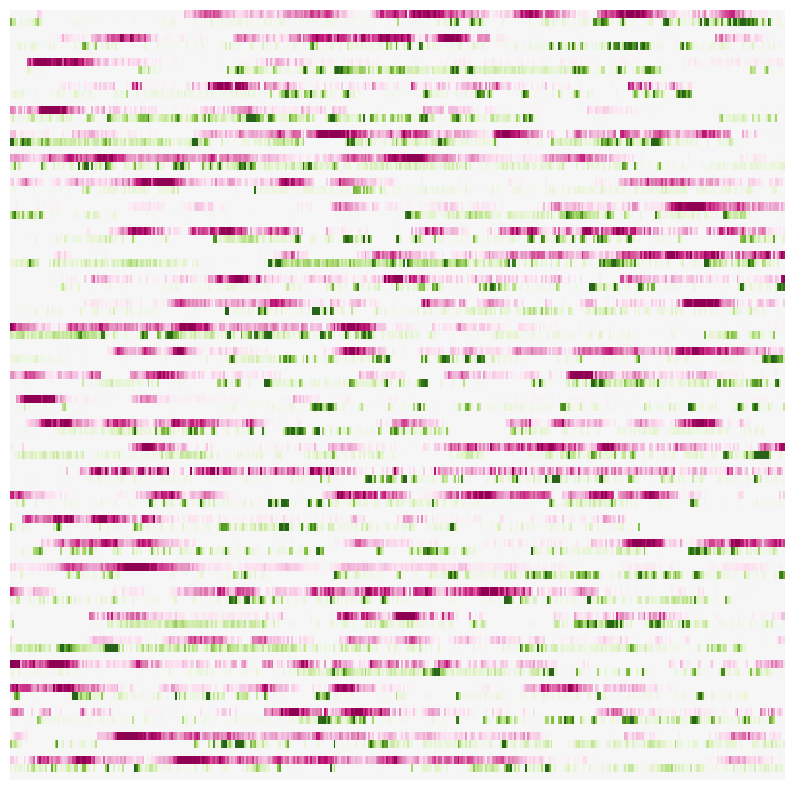

In [397]:
import umap
import umap.plot as uplt
neighbors = np.arange(16, 19, 2)
plt.figure(figsize=(10, 10))
# umapper = umap.UMAP(n_neighbors=n_, n_components=1)
# gr_mapper = umapper.fit(gr_df, )
# gr_transformed = umapper.fit_transform(gr_df)


pca = PCA(n_components=1)
gr_transformed = pca.fit_transform(gr_df)
gr_sort_idx = np.argsort(gr_transformed.flatten())

heatmap_arr = arrange_heatmap_clustered(results, gr_sort_idx, 400, spacing=1)
plt.axis("off")
plt.imshow(heatmap_arr, aspect="auto", interpolation="nearest", cmap="PiYG")


In [128]:
def label_states(arr: np.ndarray, state=1, inverse=False):
    blocks = np.cumsum(np.diff(arr, prepend=np.array([0])) != 0)
    if inverse:
        return (arr != state) * blocks
    return (arr == state) * blocks

def get_lengths(arr: np.ndarray):
    blocks = np.cumsum(np.diff(arr, prepend=np.array([0])) != 0)

    labeled = arr * blocks
    counts = np.bincount(labeled)[1:]
    return counts[counts > 0]

In [404]:
def get_burst_metrics(intensity, states):
    dS = np.diff(states, prepend=np.array([0]))

    on_off_pairs = []
    for i in np.argwhere(dS > 0).flatten(): # goes through every start
        j = np.argmax(dS[i:] < 0) + i
        if i != j:
            on_off_pairs.append((i, j))
    blocks = np.cumsum(dS != 0)
    on_labeled = (states == 1) * blocks
    on_times = np.bincount(on_labeled)[1:]
    on_idxs = np.arange(1, len(on_times) + 1)
    on_idxs = on_idxs[on_times > 0]
    on_times = on_times[on_times > 0]

    off_labeled = (states == 0) * blocks
    off_times = np.bincount(off_labeled)[1:]
    off_idxs = np.arange(1, len(off_times) + 1)
    off_idxs = off_idxs[off_times > 0]
    off_times = off_times[off_times > 0]
    on_sizes = []
    for i in on_idxs:
        on_sizes.append(np.sum(intensity * (on_labeled == i)))
    off_sizes = []
    for i in off_idxs:
        off_sizes.append(np.sum(intensity * (off_labeled == i)))
    return on_times, off_times, np.array(on_sizes), np.array(off_sizes), on_off_pairs

def batch_metrics(results):
    g_dict, r_dict = results["G"], r_dict["R"]
    g_on_times, g_off_times, g_on_sizes, g_off_sizes = [], [], [], []
    r_on_times, r_off_times, r_on_sizes, r_off_sizes = [], [], [], []
    g_pairs, r_pairs = []
    for g_trace, r_trace in zip(g_dict, r_dict):
        g_on_t, g_off_t, g_on_s, g_off_s, g_pairs = get_burst_metrics(g_trace["I"], g_trace["State"])

        r_on_t, r_off_t, r_on_s, r_off_s, r_pairs = get_burst_metrics(r_trace["I"], r_trace["State"])
        g_on_times.extend(g_on_t), g_off_times.extend(g_off_t), g_on_sizes.extend(g_on_s), g_off_sizes.extend(g_off_s)
        r_on_times.extend(r_on_t), r_off_times.extend(r_off_t), r_on_sizes.extend(r_on_s), r_off_sizes.extend(r_off_s)

def left_to_shape(x, shape, fill=np.nan):
    y = np.ones(shape) * fill
    if len(x) > 0:
        y[-len(x):] = x
    return y

def right_to_shape(x, shape, fill=np.nan):
    y = np.ones(shape) * fill
    if len(x) > 0:
        y[:len(x)] = x
    return y

def map_color(arr, color):
    new_arr = arr.copy()
    new_arr[new_arr < 0] = 0
    new_arr[new_arr > 1] = 1
    if color=="g":
        return new_arr / 2 + 0.5
    elif color=="r":
        return 0.5 - new_arr / 2

def arrange_burst_heatmap(results, sort_idx=None, slen=[30, 30, 30], spacing=1, align="g", idealized=False):
    if sort_idx is None:
        sort_idx = np.arange(len(results["G"]))
    G_df = results["G"]
    R_df = results["R"]
    # heat_map_arr = np.ones((len(G_df) * (2+spacing), max_length)) * 0.5
    heat_map_list = []
    sidx = np.cumsum(slen)
    for i, (g_trace, r_trace) in enumerate(zip(G_df, R_df)):
        g_I, g_N, g_S = g_trace["I"], g_trace["Normalized Intensity"], g_trace["State"]
        r_I, r_N, r_S = r_trace["I"], r_trace["Normalized Intensity"], r_trace["State"]
        _, _, _, _, g_pairs = get_burst_metrics(g_I, g_S)
        _, _, _, _, r_pairs = get_burst_metrics(r_I, r_S)
        if align == "g":
            pairing = g_pairs
        if align == "r":
            pairing = r_pairs
        for start, end in pairing:
            temp = np.ones(np.sum(slen)) * 0.5
            temp[0:sidx[0]] = left_to_shape(g_S[max(start-slen[0], 0):start], slen[0])
            temp[sidx[0]:sidx[1]] = np.interp(np.linspace(0, 1, slen[1]), np.linspace(0, 1, end - start), g_S[start:end])
            temp[sidx[1]:] = right_to_shape(g_S[end:min(end+slen[2], len(g_S))], slen[2])
            temp_g_fit = map_color(temp, "g")
            
            temp = np.ones(np.sum(slen)) * 0.5
            temp[0:sidx[0]] = left_to_shape(r_S[max(start-slen[0], 0):start], slen[0])
            temp[sidx[0]:sidx[1]] = np.interp(np.linspace(0, 1, slen[1]), np.linspace(0, 1, end - start), r_S[start:end])
            temp[sidx[1]:] = right_to_shape(r_S[end:min(end+slen[2], len(r_S))], slen[2])
            temp_r_fit = map_color(temp, "r")


            temp = np.ones(np.sum(slen)) * 0.5
            temp[0:sidx[0]] = left_to_shape(r_I[max(start-slen[0], 0):start], slen[0])
            temp[sidx[0]:sidx[1]] = np.interp(np.linspace(0, 1, slen[1]), np.linspace(0, 1, end - start), r_I[start:end])
            temp[sidx[1]:] = right_to_shape(r_I[end:min(end+slen[2], len(r_I))], slen[2])
            temp = temp - np.nanmin(temp)
            temp = temp / np.nanmax(temp)
            temp_r = map_color(temp, "r")

            temp = np.ones(np.sum(slen)) * 0.5
            temp[0:sidx[0]] = left_to_shape(g_I[max(start-slen[0], 0):start], slen[0])
            temp[sidx[0]:sidx[1]] = np.interp(np.linspace(0, 1, slen[1]), np.linspace(0, 1, end - start), g_I[start:end])
            temp[sidx[1]:] = right_to_shape(g_I[end:min(end+slen[2], len(g_I))], slen[2])
            temp = temp - np.nanmin(temp)
            temp = temp / np.nanmax(temp)
            temp_g = map_color(temp, "g")

            temp_space = np.ones(np.sum(slen)) * 0.5
            if align =="g":
                if idealized:
                    heat_map_list.append(temp_r_fit)
                else:
                    heat_map_list.append(temp_r)


            if align == "r":
                if idealized:
                    heat_map_list.append(temp_g_fit)
                else:
                    heat_map_list.append(temp_g)


            # heat_map_list.append(temp_r_fit)
            # heat_map_list.append(temp_r)
            # heat_map_list.append(temp_g)
            # heat_map_list.append(temp_g_fit)
            for i in range(spacing):
                heat_map_list.append(temp_space)
            
    return np.stack(heat_map_list)

on_times, off_times, on_sizes, off_sizes, on_off_pairs = get_burst_metrics(results["G"][0]["I"], results["G"][0]["State"])



In [372]:
burst_heatmap.shape

(377, 350)

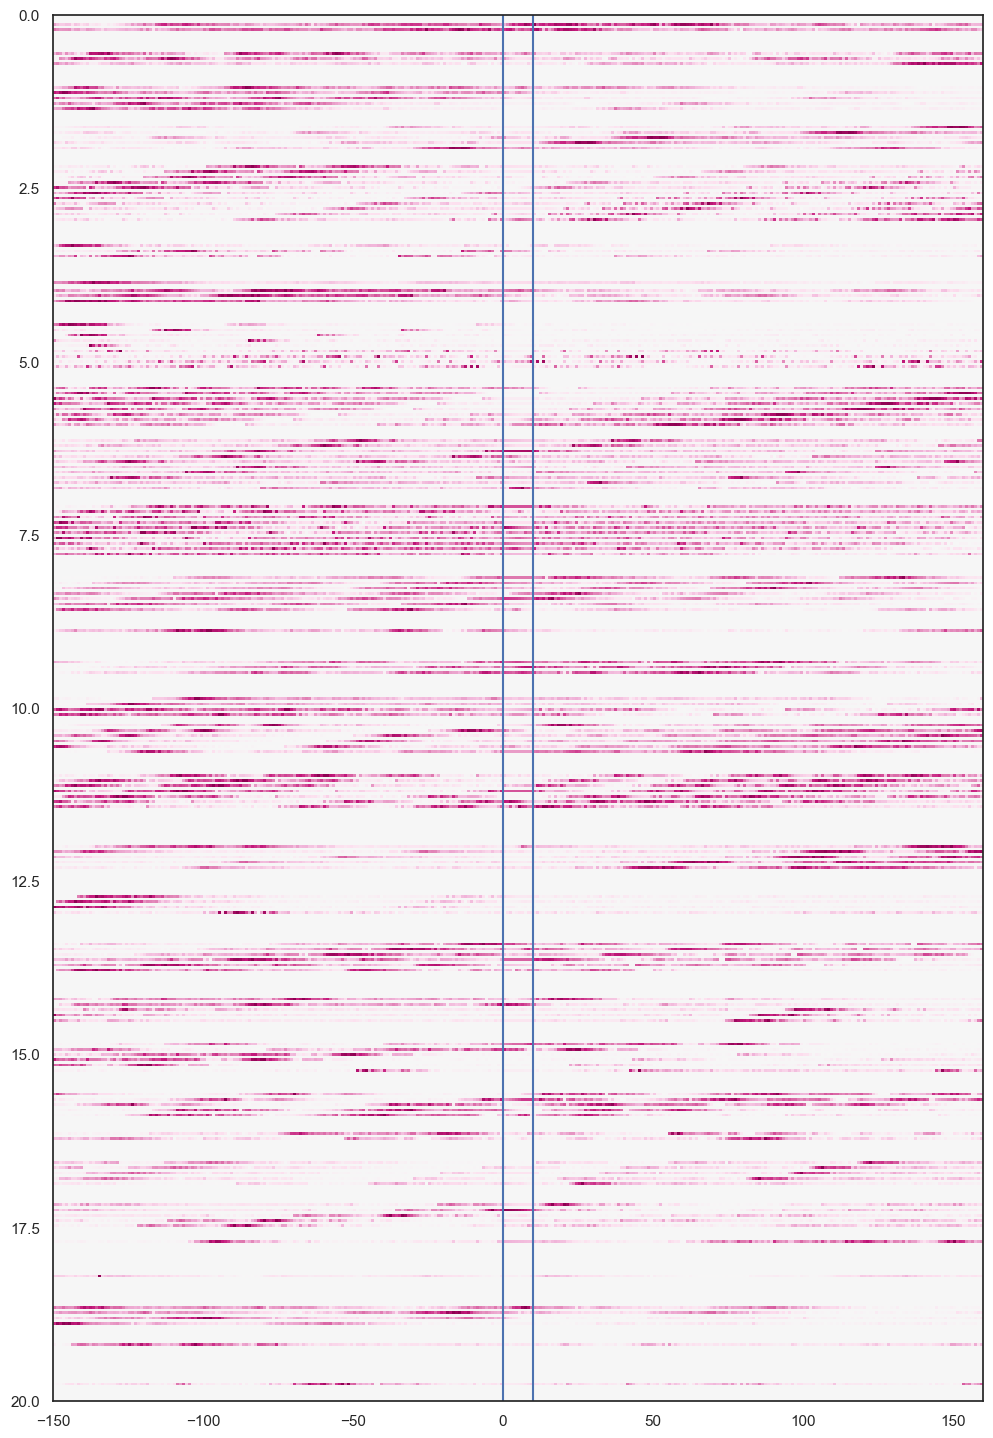

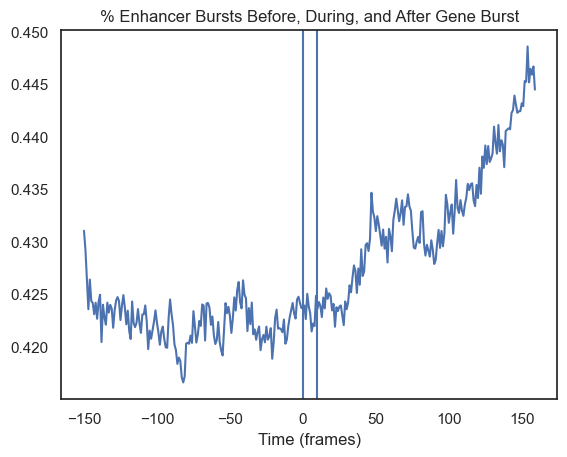

In [405]:
pre_length = 150
mid_length = 10
post_length = 150
burst_heatmap = arrange_burst_heatmap(results, slen=[pre_length, mid_length, post_length], spacing=1, align="g", idealized=False)
cropped = burst_heatmap[burst_heatmap[:, 0]> 0]
cropped = cropped[cropped[:, -1] > 0]

plt.figure(figsize=(12, 18))
plt.imshow(cropped, aspect="auto", interpolation="nearest", cmap="PiYG", extent=[-pre_length, mid_length + post_length, 20, 0])
plt.clim([0, 1])
plt.axvline(x=0)
plt.axvline(x=mid_length)
plt.show()

mean_burst = np.nanmean(burst_heatmap, axis=0)
std_burst = np.nanstd(burst_heatmap, axis=0)

plt.plot(np.arange(burst_heatmap.shape[1]) - pre_length, mean_burst)
plt.title("% Enhancer Bursts Before, During, and After Gene Burst")
plt.xlabel("Time (frames)")
# plt.fill_between(np.arange(burst_heatmap.shape[1]) - pre_length, mean_burst - 1 * std_burst, mean_burst + 1 * std_burst, alpha=0.3)
plt.axvline(x=0)
plt.axvline(x=mid_length)
plt.show()

In [374]:
cropped.shape

(149, 350)

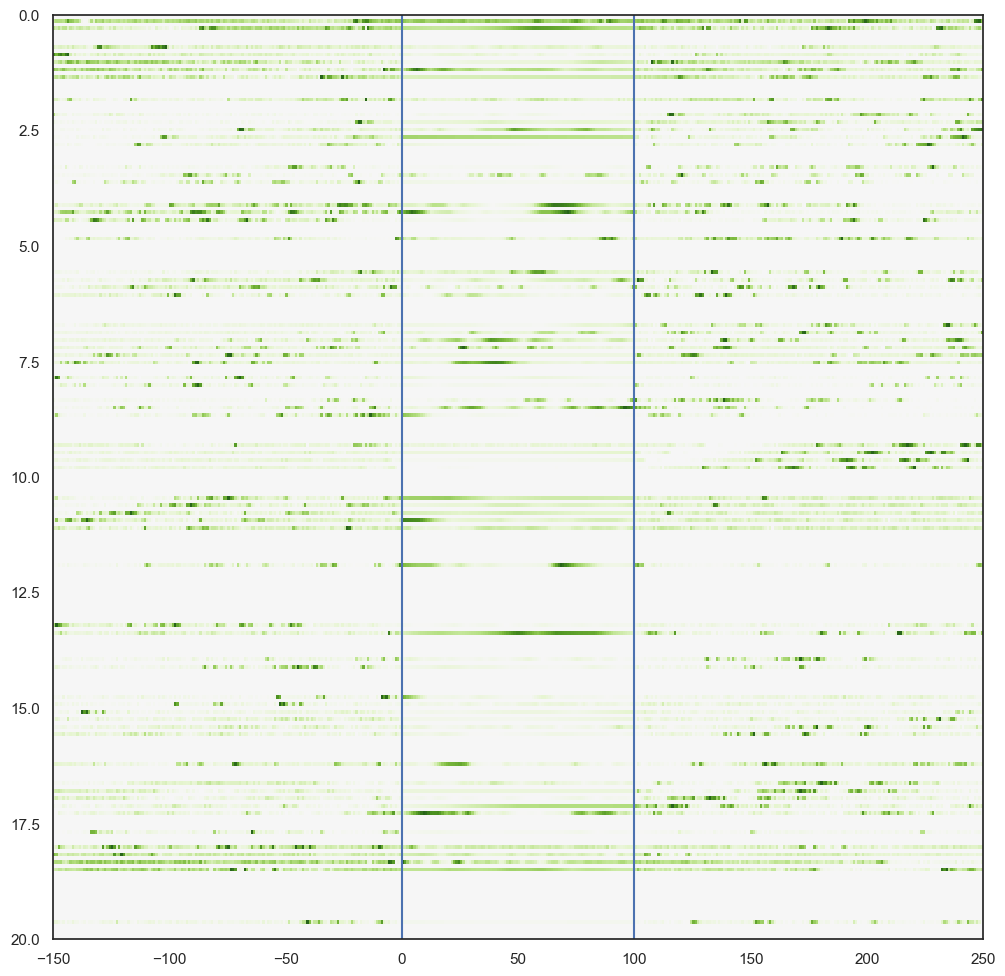

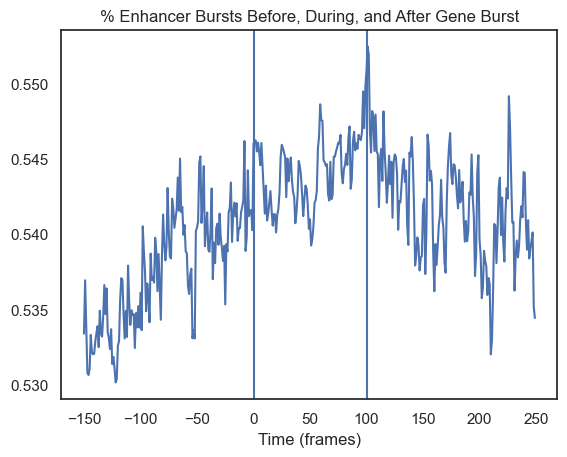

In [406]:
pre_length = 150
mid_length = 100
post_length = 150
burst_heatmap = arrange_burst_heatmap(results, slen=[pre_length, mid_length, post_length], spacing=1, align="r")
cropped = burst_heatmap[burst_heatmap[:, 0]> 0]
cropped = cropped[cropped[:, -1] > 0]

plt.figure(figsize=(12, 12))
plt.imshow(cropped, aspect="auto", interpolation="nearest", cmap="PiYG", extent=[-pre_length, mid_length + post_length, 20, 0])
plt.clim([0, 1])
plt.axvline(x=0)
plt.axvline(x=mid_length)
plt.show()

mean_burst = np.nanmean(burst_heatmap, axis=0)
std_burst = np.nanstd(burst_heatmap, axis=0)

plt.plot(np.arange(burst_heatmap.shape[1]) - pre_length, mean_burst)
plt.title("% Enhancer Bursts Before, During, and After Gene Burst")
plt.xlabel("Time (frames)")
# plt.fill_between(np.arange(burst_heatmap.shape[1]) - pre_length, mean_burst - 1 * std_burst, mean_burst + 1 * std_burst, alpha=0.3)
plt.axvline(x=0)
plt.axvline(x=mid_length)
plt.show()

In [368]:
burst_heatmap.shape

(179, 350)

In [ ]:
pca = PCA(n_components=1)
pca.fit()